In [1]:
from pathlib import Path
from collections import defaultdict
from itertools import cycle

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None) # don't truncate cell contents


import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# library &amp; dataset
import seaborn as sns

import re
# for statistical testing
from scipy import stats
# from statsmodels.stats import weightstats as stests
from statsmodels.distributions.empirical_distribution import ECDF

from sklearn.preprocessing import MinMaxScaler


In [2]:
data_dir = Path('../hotel/500k')
scored_data = [
    'trip_hotels.pkl',
    'trip_hotels.gen_sts_scores.pkl',
    'trip_hotels.response_ppl_scores.pkl',
    'trip_hotels.zipf_dist_scores.pkl',
    'trip_hotels.response_tfidf_scores_norm.pkl',
    'trip_hotels.rev_resp_tfidf_scores.pkl',
    'trip_hotels.rev_resp_sts_scores.pkl',
    ]

df = pd.concat([pd.read_pickle(data_dir / f) for f in scored_data], axis=1)
print(len(df))
df.drop(columns=['Unnamed: 0'], inplace=True)
# df.to_csv('../hotel/500k/trip_hotels.scored.csv')
print(df.columns)
split = 'train'
df = df[df['split'] == split]
print(len(df))

500000
Index(['domain', 'rating', 'review_author', 'response_author', 'review_clean',
       'response_clean', 'sentiment', 'db_internal_id', 'establishment',
       'trip_id', 'trip_url', 'country', 'split',
       'score:review_response_length_ratio', 'score:response_sentence_length',
       'score:genericness_semantic_avg', 'score:genericness_length_ratio',
       'score:review_response_wmd', 'rrgen_id',
       'score:genericness_sent_level_sts_avg', 'score:response_text_ppl',
       'score:response_freq_distro_ratio', 'score:response_tfidf',
       'score:rev_resp_tfidf', 'score:rev_resp_sts'],
      dtype='object')
450367


In [3]:
print(df['score:rev_resp_sts'].describe())
print(df['score:review_response_wmd'].describe())
print(df['score:response_tfidf'].describe())
print(df['score:rev_resp_tfidf'].describe())

count    450367.000000
mean          0.470155
std           0.134365
min          -0.138696
25%           0.381872
50%           0.478102
75%           0.567292
max           0.965809
Name: score:rev_resp_sts, dtype: float64
count    450367.000000
mean          4.385127
std           0.397940
min           0.273003
25%           4.131311
50%           4.401362
75%           4.655734
max           7.202138
Name: score:review_response_wmd, dtype: float64
count    4.503670e+05
mean              inf
std               NaN
min      5.772067e-01
25%      1.249172e+00
50%      1.336810e+00
75%      1.435228e+00
max               inf
Name: score:response_tfidf, dtype: float64
count    450367.000000
mean          0.114189
std           0.100383
min           0.000000
25%           0.032699
50%           0.091231
75%           0.170445
max           0.947225
Name: score:rev_resp_tfidf, dtype: float64


In [4]:
df['review_clean_len'] = df['review_clean'].apply(lambda x: len(x.split()))
df['response_clean_len'] = df['response_clean'].apply(lambda x: len(x.split()))


In [12]:
# all cols:
# len(df[(np.abs(stats.zscore(df)) < 3).all(axis=1)])

fontsize = 16

score_columns = {
#     'score:review_response_length_ratio': {'label': 'review-response len ratio'},
#     'score:response_sentence_length': ,
#     'score:genericness_semantic_avg': ,
#     'score:genericness_length_ratio': ,
#     'score:review_response_wmd': 'review-response WMD',
    'score:response_freq_distro_ratio': {'label': 'lex. freq.', 'min': 0.7, 'max': 0.883},
#     'score:response_tfidf': {'label': 'tgt TF-IDF', 'min': 1.37},
    'score:genericness_sent_level_sts_avg': {'label': 'sent. avg.', 'max': 0.7},
    'score:response_text_ppl': {'label': 'LM PPL', 'min': 23.5, 'max': 50},
#     'score:rev_resp_tfidf': {'label': 'src-tgt TF-IDF', 'min': 0.118, 'max': 0.6},
#     'score:rev_resp_sts': {'label': 'src-tgt STS', 'min': 0.51, 'max': 0.80},    
}

def remove_outliers(df, col_name):
    """
    https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    """
    orig_len = len(df)
    df = df[~df[col_name].isin([np.nan, np.inf, -np.inf])]
    df_filt = df[(np.abs(stats.zscore(df[col_name])) < 3)]
    print(f'removed {orig_len-len(df_filt)} outliers from df with {orig_len} items based on {col_name}')
    return df_filt

def compute_ecdf(df, col_name):
    df_filt = df[~df[col_name].isin([np.nan, np.inf, -np.inf])]
    ecdf = ECDF(df_filt[col_name])
    return ecdf

def compute_ecdf_without_outliers(df, col_name):
    df_filt = remove_outliers(df, col_name)
    ecdf = ECDF(df_filt[col_name])
    return ecdf

def compute_normalised_ecdf(df, col_name, split=split):

    if split is not None:
        df = df[df['split'] == split]
    df = df[~df[col_name].isin([np.nan, np.inf, -np.inf])]
    s = remove_outliers(df, col_name)[col_name]
    # create a scaler object
    scaler = MinMaxScaler()

    # fit and transform the data
    s = scaler.fit_transform(s.to_numpy().reshape(-1, 1)).reshape(-1)

    ecdf = ECDF(s)
    return ecdf



removed 3518 outliers from df with 450367 items based on score:response_freq_distro_ratio
removed 2072 outliers from df with 450367 items based on score:genericness_sent_level_sts_avg
removed 935 outliers from df with 450367 items based on score:response_text_ppl


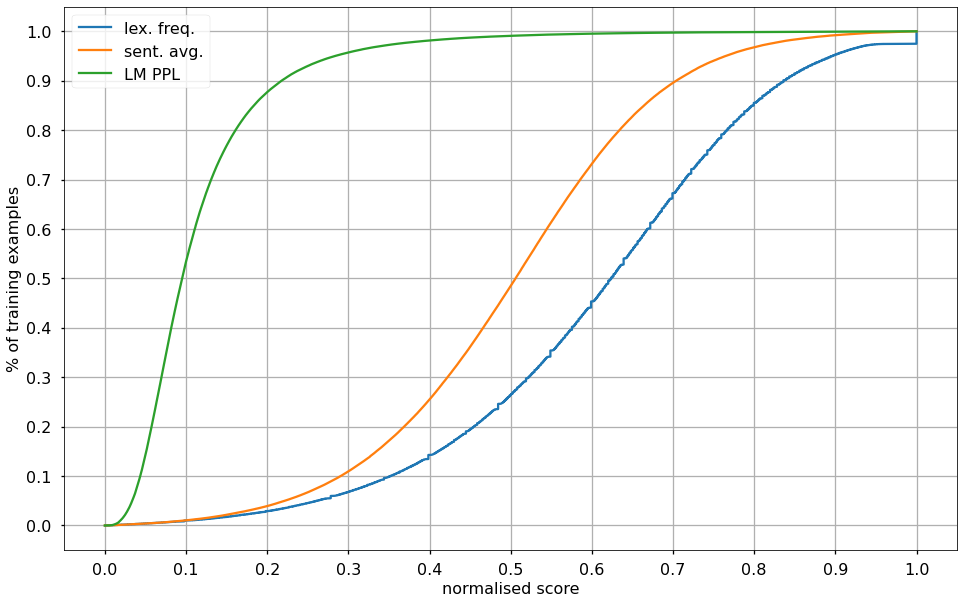

In [13]:
# normalised (all scores on one plot)
with plt.style.context('seaborn-talk'):
    
    f, ax = plt.subplots(figsize=(16, 10))

    for col in score_columns:    
        ecdf = compute_normalised_ecdf(df, col, )
        line, = ax.plot(ecdf.x, ecdf.y)
        line.set_label(score_columns[col]['label'])

    ax.set_ylabel('% of training examples', fontsize=fontsize)
    ax.set_yticks(np.arange(0,1.1, 0.1))
    ax.set_xlabel('normalised score', fontsize=fontsize)
    ax.set_xticks(np.arange(0,1.1, 0.1))
    ax.grid()
    ax.legend(fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

removed 3518 outliers from df with 450367 items based on score:response_freq_distro_ratio
removed 2072 outliers from df with 450367 items based on score:genericness_sent_level_sts_avg
removed 935 outliers from df with 450367 items based on score:response_text_ppl


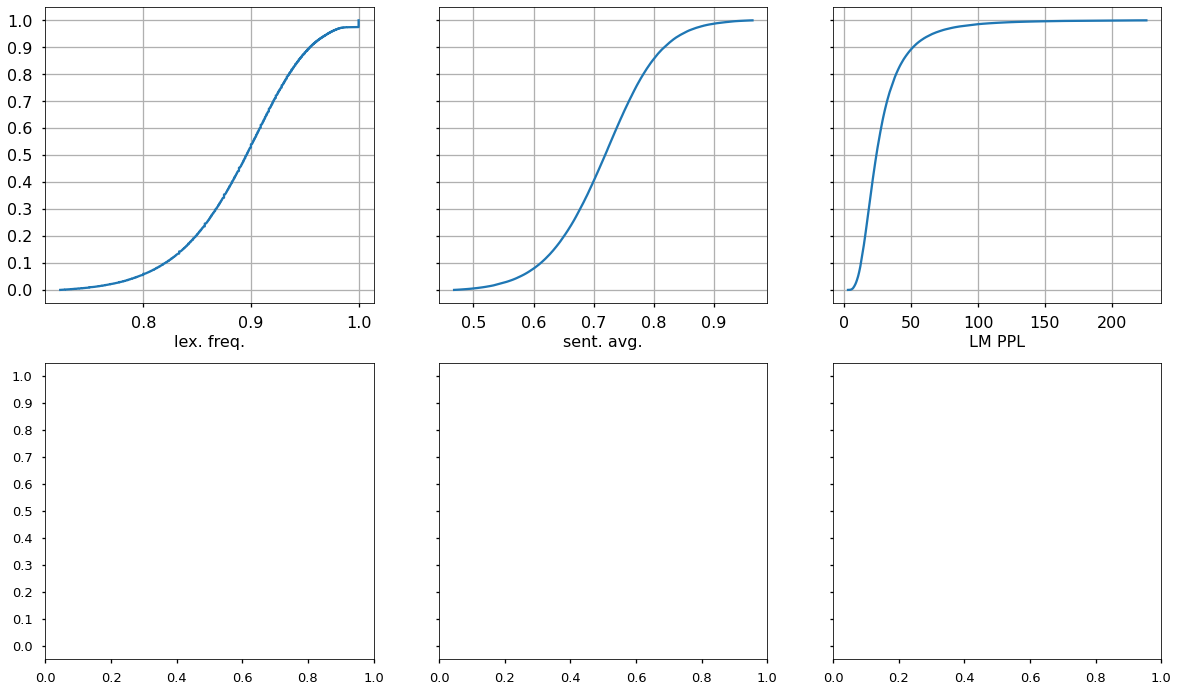

In [14]:
score_column_keys = list(score_columns.keys())

with plt.style.context('seaborn-talk'):
    fs = 16
    f, axs = plt.subplots(2, 3, figsize=(20, 12), sharey=True)
    for i, ax in enumerate(axs.reshape(-1)): 
        if i > len(score_columns)-1:
            break
        ecdf = compute_ecdf_without_outliers(df, score_column_keys[i])
        ax.plot(ecdf.x, ecdf.y)
        ax.set_xlabel(score_columns[score_column_keys[i]]['label'], fontsize=fs)
        ax.set_yticks(np.arange(0,1.1, 0.1))
    #     ax.set_xticks(np.arange(min(ecdf.x),max(ecdf.x)))
        ax.grid()
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

    # axs.set_ylabel('% of training examplescore:review_response_wmds', fontsize=fontsize)
    # axs.set_xlabel('normalised score', fontsize=fontsize)
    

In [15]:
print(plt.style.available)
print(sns.color_palette("husl"))

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701), (0.7350228985632719, 0.5952719904750953, 0.1944419133847522), (0.3126890019504329, 0.6928754610296064, 0.1923704830330379), (0.21044753832183283, 0.6773105080456748, 0.6433941168468681), (0.23299120924703914, 0.639586552066035, 0.9260706093977744), (0.9082572436765556, 0.40195790729656516, 0.9576909250290225)]


Text(0.5, 0, 'normalised score')

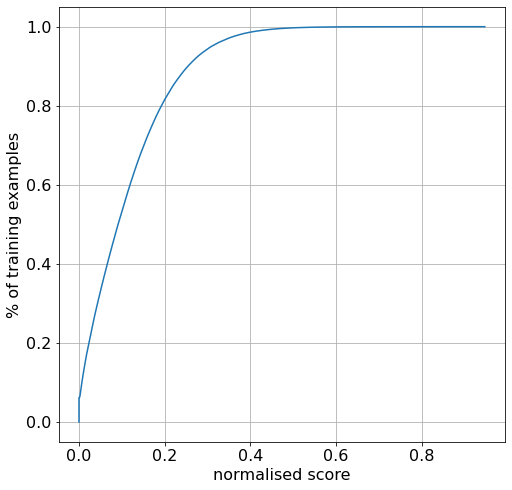

In [16]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
ecdf = compute_ecdf(df, 'score:rev_resp_tfidf')
ax.plot(ecdf.x, ecdf.y)
# ax.xlabel('score:review_response_wmd', fontsize=fs)
# ax.yticks(np.arange(0,1.1, 0.1))
# ax.set_xticks(np.arange(min(ecdf.x),max(ecdf.x)))
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=fontsize)

ax.set_ylabel('% of training examples', fontsize=fontsize)
ax.set_xlabel('normalised score', fontsize=fontsize)

removed 3518 outliers from df with 450367 items based on score:response_freq_distro_ratio
0.7 0.883
removed 2072 outliers from df with 450367 items based on score:genericness_sent_level_sts_avg
-inf 0.7
removed 935 outliers from df with 450367 items based on score:response_text_ppl
23.5 50


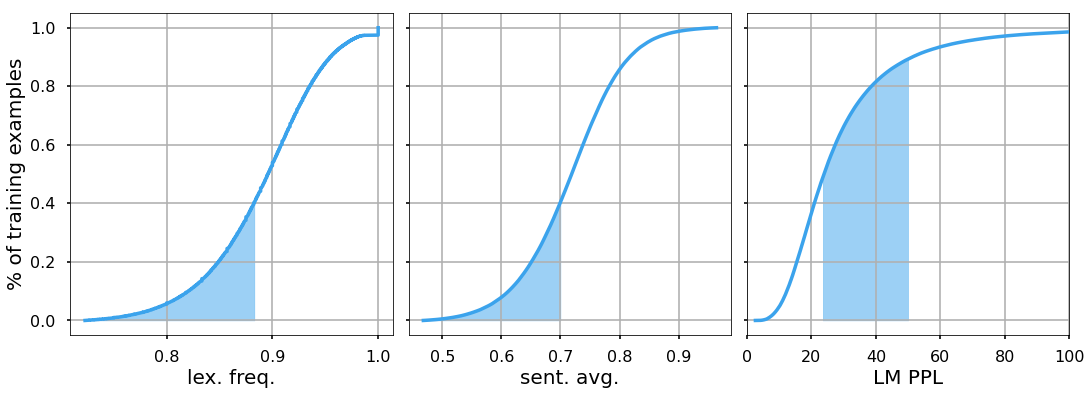

In [17]:
cm = sns.color_palette("husl")

fill = True
fs = 20

with plt.style.context('seaborn-poster'):

    f, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
#     f.add_subplot(111, frameon=False)
#     plt.xlabel('normalised score', fontsize=fontsize)
    f.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    plt.ylabel('% of training examples', fontsize=fs)
    # hide tick and tick label of the big axis
    
    for i, ax in enumerate(axs.reshape(-1)): 
        if i > len(score_columns)-1:
            break
        key = list(score_columns.keys())[i]
        
        
#         if key == 'score:rev_resp_tfidf': # outliers range is > 4000
#             ecdf = compute_ecdf(df, key)
#         else:
        ecdf = compute_ecdf_without_outliers(df, key)
            
        ax.plot(ecdf.x, ecdf.y, color=cm[-2], lw=3.5)# label=score_columns[key])
        ax.set_xlabel(score_columns[key]['label'], fontsize=fs)
        ax.set_yticks(np.arange(0,1.1, 0.2), minor=False)

        if key == 'score:response_text_ppl':
            ax.set_xlim(left=0, right=100)

        elif key == 'score:rev_resp_sts':
            ax.set_xticks(np.arange(0.0,1.0, 0.2))
        
        elif key == 'score:response_freq_distro_ratio':
            ax.set_xticks(np.arange(0.7,1.0, 0.1), minor=False)
        
        elif key == 'score:rev_resp_tfidf':
            ax.set_xticks(np.arange(0.0,0.41, 0.1), minor=True)
        
        ax.grid()
        x0 = score_columns[key].get('min', min(ecdf.x))
        x1 = score_columns[key].get('max', max(ecdf.x))
        print(x0, x1)
        # shade areas within thresholds
        if fill:
            ax.fill_between(ecdf.x, ecdf.y, where=(ecdf.x > x0) & (ecdf.x < x1), color=cm[-2], alpha=0.5)

    plt.tight_layout()
    
    if fill:
        plt.savefig('./plots/score_ecdf_plots_filled_3.pdf', dpi=300)
        plt.savefig('./plots/score_ecdf_plots_filled_3.png', dpi=300)
#     else:
#         plt.savefig('./plots/score_ecdf_plots.pdf', dpi=300)
#         plt.savefig('./plots/score_ecdf_plots.png', dpi=300)



In [19]:
print(df.columns)
df['response_wlen'] = df['response_clean'].apply(lambda x: len(x.split()))

Index(['domain', 'rating', 'review_author', 'response_author', 'review_clean',
       'response_clean', 'sentiment', 'db_internal_id', 'establishment',
       'trip_id', 'trip_url', 'country', 'split',
       'score:review_response_length_ratio', 'score:response_sentence_length',
       'score:genericness_semantic_avg', 'score:genericness_length_ratio',
       'score:review_response_wmd', 'rrgen_id',
       'score:genericness_sent_level_sts_avg', 'score:response_text_ppl',
       'score:response_freq_distro_ratio', 'score:response_tfidf',
       'score:rev_resp_tfidf', 'score:rev_resp_sts', 'review_clean_len',
       'response_clean_len'],
      dtype='object')


removed 3518 outliers from df with 450367 items based on score:response_freq_distro_ratio
removed 2072 outliers from df with 450367 items based on score:genericness_sent_level_sts_avg
removed 935 outliers from df with 450367 items based on score:response_text_ppl


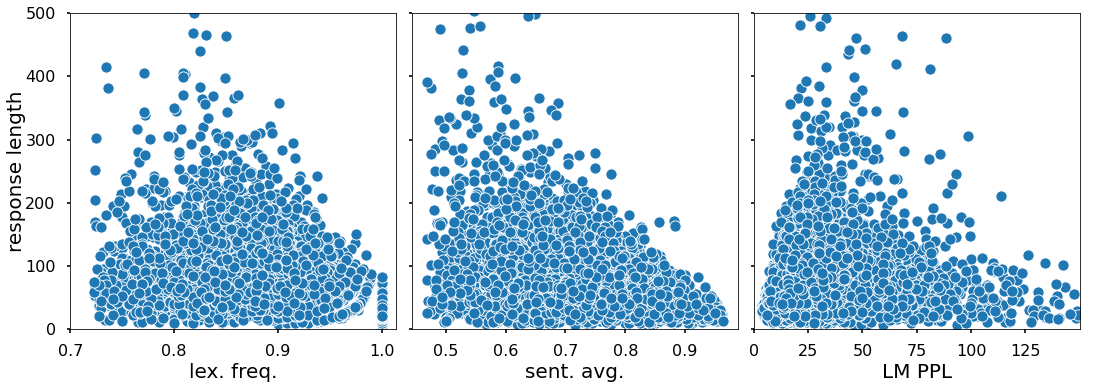

In [20]:
with plt.style.context('seaborn-poster'):

#     f, axs = plt.subplots(1, 6, figsize=(22, 6), sharey=True)
    f, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
    f.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    plt.ylabel('response length', fontsize=fs)
    # hide tick and tick label of the big axis
    
    for i, ax in enumerate(axs.reshape(-1)): 
        if i > len(score_columns)-1:
            break
        key = list(score_columns.keys())[i]
        
        if key == 'score:rev_resp_tfidf':
            filt_df = df
            print(f'removed 0 outliers from df with 450367 items based on score:rev_resp_tfidf')
        else:
            filt_df = remove_outliers(df, key)

        sns.scatterplot(data=filt_df.sample(10000), x=key, y='response_wlen', ax=ax)
        ax.set_xlabel(score_columns[key]['label'], fontsize=fs)
        ax.set_ylabel(None)
        ax.set_ylim(bottom=0, top=500)
        
        if key == 'score:response_text_ppl':
            ax.set_xlim(left=0, right=150)
            ax.set_xticks(np.arange(0, 150, 25))

        elif key == 'score:rev_resp_sts':
            ax.set_xticks(np.arange(0.0,1.0, 0.2))
        
        elif key == 'score:response_freq_distro_ratio':
            ax.set_xticks(np.arange(0.7,1.0, 0.1), minor=False)
            
    plt.tight_layout()

    plt.savefig('./plots/score_v_resp_len_3.pdf', dpi=300)
    plt.savefig('./plots/score_v_resp_len_3.png', dpi=300)


removed 3518 outliers from df with 450367 items based on score:response_freq_distro_ratio
removed 2072 outliers from df with 450367 items based on score:genericness_sent_level_sts_avg
removed 935 outliers from df with 450367 items based on score:response_text_ppl


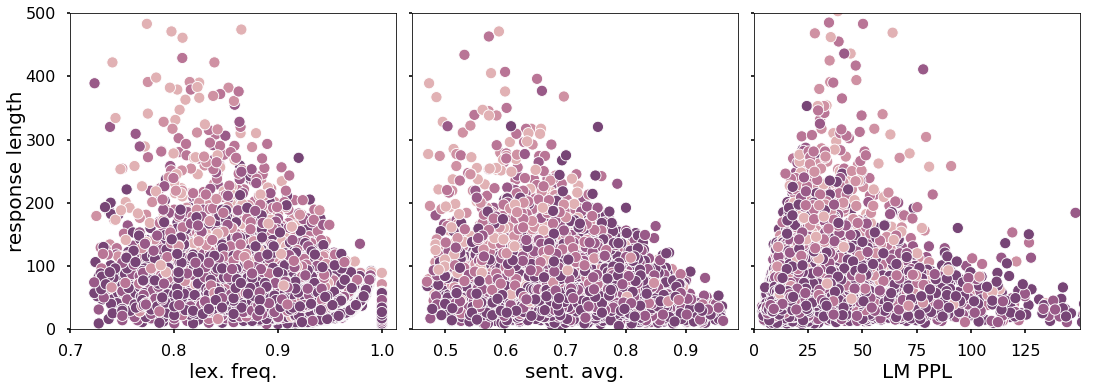

In [21]:
# reverse_rating_map = {5:1, 4:2, 3:3, 2:4, 1:5}

with plt.style.context('seaborn-poster'):

#     f, axs = plt.subplots(1, 6, figsize=(22, 6), sharey=True)
    f, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
    f.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    plt.ylabel('response length', fontsize=fs)
    # hide tick and tick label of the big axis
    
    for i, ax in enumerate(axs.reshape(-1)): 
        if i > len(score_columns)-1:
            break
        key = list(score_columns.keys())[i]

        if key == 'score:rev_resp_tfidf':
            filt_df = df
            print(f'removed 0 outliers from df with 450367 items based on score:rev_resp_tfidf')
        else:
            filt_df = remove_outliers(df, key)
        
        sns.scatterplot(data=filt_df.sample(10000), x=key, y='response_wlen', 
                        hue='rating', hue_norm=(0, 7), ax=ax, legend=True)
        
        ax.set_xlabel(score_columns[key]['label'], fontsize=fs)
        
        ax.set_ylabel(None)
        ax.set_ylim(bottom=0, top=500)
#         ax.tick_params(labelsize=fs)
#         ax.legend(None)
        
        if key == 'score:response_text_ppl':
            ax.set_xlim(left=0, right=150)
            ax.set_xticks(np.arange(0, 150, 25))

        elif key == 'score:rev_resp_sts':
            ax.set_xticks(np.arange(0.0,1.0, 0.2))
        
        elif key == 'score:response_freq_distro_ratio':
            ax.set_xticks(np.arange(0.7,1.0, 0.1), minor=False)
            
        if i != 5:
            ax.legend().set_visible(False)
            
    plt.tight_layout()

    plt.savefig('./plots/score_v_resp_len_rating_3.pdf', dpi=300)
    plt.savefig('./plots/score_v_resp_len_rating_3.png', dpi=300)


In [23]:
def filter_df(df, col_name, min_threshold=0.0, max_threshold=1.0, verbose=True):
    orig_len = len(df)
    if verbose:
        print(df[col_name].describe())
    df = df[(df[col_name] > min_threshold) & (df[col_name] < max_threshold)]
    print(f'\nRemoved {orig_len-len(df)} items. New length {len(df)} ({(len(df)/orig_len)*100:.2f}%)\n')
    if verbose:
        print(df['split'].value_counts())
        print()
        print(df[col_name].describe())
    return df
  
# def filter_df_by_percent(df, col_name, lower_bound=0.0, upper_bound=0.9):
#     orig_len = len(df)
#     print(df[col_name].describe())
#     df['rank'] = df[col_name].rank(pct=True)
#     df = df[(df['rank'] > lower_bound) & (df[col_name] < upper_bound)]
#     print(f'\nRemoved {orig_len-len(df)} items. New length {len(df)} ({(len(df)/orig_len)*100:.2f}%)\n')
#     print(df['split'].value_counts())
#     print()
#     print(df[col_name].describe())
#     return df

In [24]:
# # Filter criteria: score:genericness_sent_level_sts_avg
# min_threshold=0.0
# max_threshold=0.70

# # df_filt = filter_df_by_percent(df, 'score:genericness_sent_level_sts_avg', lower_bound=0.0, upper_bound=0.9)
# df_filt = filter_df(df, 'score:genericness_sent_level_sts_avg', min_threshold, max_threshold)
# df_filt.sample(n=100)[['review_clean', 'response_clean', 'score:genericness_sent_level_sts_avg']]

# # Filter criteria: score:response_freq_distro_ratio
# min_threshold=0.0
# max_threshold=0.883

# # df_filt = filter_df_by_percent(df, 'score:response_freq_distro_ratio', 0.0, 0.9)
# df_filt = filter_df(df, 'score:response_freq_distro_ratio', min_threshold, max_threshold)
# df_filt.sample(n=10)

# # Filter criteria: score:response_text_ppl
# min_threshold=23.5
# max_threshold=50

# # df_filt = filter_df_by_percent(df, 'score:response_text_ppl', lower_bound=0.0, upper_bound=0.9)
# df_filt = filter_df(df, 'score:response_text_ppl', min_threshold, max_threshold)
# df_filt.sample(n=10)

# # Filter criteria: score:response_tfidf
# min_threshold=1.37
# max_threshold=1.8
# df_filt = filter_df(df, 'score:response_tfidf', min_threshold, max_threshold)
# df_filt.sample(n=10)


# Filter criteria: score:rev_resp_tfidf
min_threshold=0.118
max_threshold=0.6
df_filt = filter_df(df, 'score:rev_resp_tfidf', min_threshold, max_threshold)
print(len(df_filt))
df_filt.sample(n=10)


count    450367.000000
mean          0.114189
std           0.100383
min           0.000000
25%           0.032699
50%           0.091231
75%           0.170445
max           0.947225
Name: score:rev_resp_tfidf, dtype: float64

Removed 268803 items. New length 181564 (40.31%)

train    181564
Name: split, dtype: int64

count    181564.000000
mean          0.212335
std           0.080231
min           0.118001
25%           0.150405
50%           0.191420
75%           0.253176
max           0.599990
Name: score:rev_resp_tfidf, dtype: float64
181564


,domain,rating,review_author,response_author,review_clean,response_clean,sentiment,db_internal_id,establishment,trip_id,trip_url,country,split,score:review_response_length_ratio,score:response_sentence_length,score:genericness_semantic_avg,score:genericness_length_ratio,score:review_response_wmd,rrgen_id,score:genericness_sent_level_sts_avg,score:response_text_ppl,score:response_freq_distro_ratio,score:response_tfidf,score:rev_resp_tfidf,score:rev_resp_sts,review_clean_len,response_clean_len,response_wlen
37491,Hotel,5,downunder45,Classic H,"Very relaxing holiday place ---SEP--- We stayed for a full week and loved it. The place is very peaceful ( it was off-season) and we had plenty of time at the pool or one of the near by beaches. We found our unit well maintained and very clean. The personal is extremely helpful in case you need something. If you don't want to cook there is the 'Recreational Club' about 10 minutes walk away. They serve good, reasonably priced meals. We would love to go back to the Pacific Palms any day. A great place to chill out","Hi downunder45, Thanks so much for taking the time to share your review. So pleased you were able to chill out by the pool. We are glad the room was up to your standards. We hope to see you again very soon.",3 -2 3,232620,Pacific Palms Resort,1147632,https://www.tripadvisor.com.au/Hotel_Review-g3734403-or60-d1147632-Reviews-Pacific_Palms_Resort-Blueys_Beach_Pacific_Palms_New_South_Wales.html,AU,train,2.000000,4,0.848834,0.000000,4.428422,2340880,0.808611,15.569574,0.957447,1.162104,0.123893,0.494045,98,42,42
285564,Hotel,3,Phil Cook,Peppers-Queenstown,Queenstown is a beautiful place and Peppers a good location to stay ---SEP--- No matter where you stay in Queenstown it is hard to not love the location. Peppers offered a reasonable place to stay without being excellent. Our 2 bedroom apartment was clean and the fire and view were great. It is a bit of a trek to get from reception to the rear complex however once you know you can access you room from the back street it is manageable. Even though the breakfast facilities don't quite meet the expectations if you forego breakfast included and eat in town or one of the other better hotels with a view it is much nicer.,"Hi Phil, Thanks for taking the time to provide feedback, it's all very important to us. You have hit the nail on the head with location as Peppers Beacon has one of the best locations in Queenstown. Yes Peppers Beacon comprises of two buildings, however these buildings are connected via a central courtyard and also underground carpark, both methods provide guest access between the buildings. This maybe easier for your next stay, than using the street behind the hotel. I'm sorry to hear that our breakfast lounge did not live up to your expectations. Kind regards, Your Guest Relations Team",2 -2 2,40291,Peppers Beacon Queenstown,646869,https://www.tripadvisor.co.nz/Hotel_Review-g255122-or270-d646869-Reviews-Peppers_Beacon_Queenstown-Queenstown_Otago_Region_South_Island.html,NZ,train,1.000000,5,0.587642,0.000000,4.072234,799453,0.652255,39.918537,0.787611,1.364700,0.226460,0.739192,115,100,100
210128,Hotel,4,n01smiles2000,BathDeputyManager,"Good hotel and good location ---SEP--- Stayed for a hen weekend in April and it was great. Rooms were a good size with everything we needed. A little road noise but not too bad. Ideal location for exploring bath and a good price, Breakfast was good with a selection of foods to choose from. Parking onsite is ideal and reasonably priced. Hotel can be alittle noisy with the doors banging and parties coming in late but ok for a few nights.","Dear Guest, Thank you for taking the time to review our hotel, we appreciate all guests’ feedback to ensure we can keep a consistently good service. I am pleased to see you had an enjoyable stay with us, and you found our rooms to be of a good size. As mentioned previously our location is in an ideal spot for tourists visiting Bath, being able to leave c

0.7 0.883

Removed 268296 items. New length 182071 (40.43%)

[20000, 40000, 60000, 80000, 100000]
['20k', '40k', '60k', '80k', '100k']
None 0.7

Removed 267626 items. New length 182741 (40.58%)

23.5 50

Removed 268443 items. New length 181924 (40.39%)



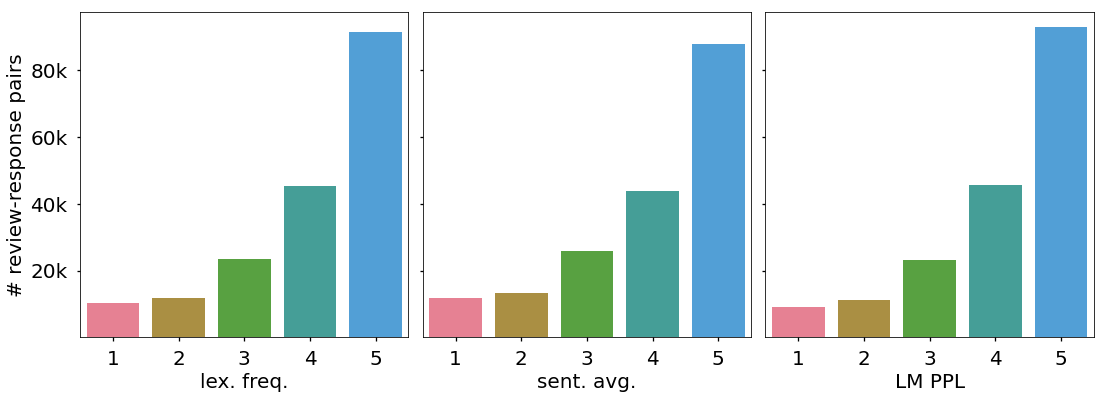

In [25]:
cm = sns.color_palette("husl")
fill = False
fs = 20

with plt.style.context('seaborn-talk'):

#     f, axs = plt.subplots(1, 6, figsize=(22, 7), sharey=True)
    f, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
    f.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    
    # hide tick and tick label of the big axis
    
    for i, ax in enumerate(axs.reshape(-1)): 
        if i > len(score_columns)-1:
            break
        key = list(score_columns.keys())[i]
        print(score_columns[key].get('min'), score_columns[key].get('max'))
        df_filt = filter_df(df, key, score_columns[key].get('min', 0), score_columns[key].get('max', 1000), verbose=False)
        sns.countplot(x='rating', data=df_filt, ax=ax, palette=cm)
         
#         sns.countplot(ecdf.x, ecdf.y, color=cm[-2], lw=3.5)# label=score_columns[key])
        ax.set_xlabel(score_columns[key]['label'], fontsize=fs)
        ax.tick_params(labelsize=fs)
        
    
        if i == 0:
            ax.set_ylabel('# review-response pairs', fontsize=fs)
            yticks = [int(x) for x in ax.get_yticks() if x > 1 and x < 110000]
            ylabels = [str(x//1000) + 'k' for x in yticks]
            print(yticks)
            print(ylabels)
            ax.set_yticks(yticks)
            ax.set_yticklabels(ylabels)
            
        else:
            ax.set_ylabel(None)

    plt.tight_layout()

#     plt.savefig('./plots/filter_method_on_review_ratings.pdf', dpi=300)
#     plt.savefig('./plots/filter_method_on_review_ratings.png', dpi=300)

    plt.savefig('./plots/filter_method_on_review_ratings_3.pdf', dpi=300)
    plt.savefig('./plots/filter_method_on_review_ratings_3.png', dpi=300)



In [31]:
# sample_size = 10000
# df.sample(n=sample_size).to_csv(f'../data/hotel/500k/trip_hotels.scored_s{sample_size}.csv', sep=',')



In [21]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.histplot(df['score:genericness_sent_level_sts_avg'], bins=100, alpha=0.5, kde=False, ax=ax)
ax.set_xlim(0.2,1.1)
ax.set_xticks(list(np.arange(0.2, 1.1, 0.05)))
ax.set_xlabel('Target text generic sentence ratio')
ax.set_ylabel('Count')

In [107]:
print(df['score:genericness_sent_level_sts_avg'].describe())

count    450367.000000
mean          0.715998
std           0.082668
min           0.301155
25%           0.664494
50%           0.718755
75%           0.769776
max           0.996356
Name: score:genericness_sent_level_sts_avg, dtype: float64


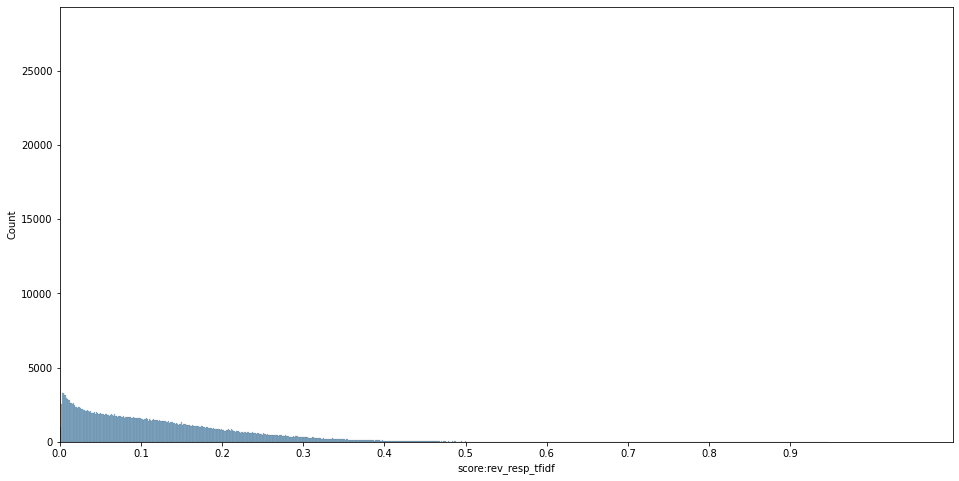

In [16]:

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.histplot(df['score:rev_resp_tfidf'], bins=1000, alpha=0.5, kde=False, ax=ax)
ax.set_xlim(0.2,1.1)
ax.set_xticks(list(np.arange(0, 1, 0.1)))
# ax.set_xlabel('Target text generic sentence ratio')
# ax.set_ylabel('Count')

In [39]:
print(df['score:response_freq_distro_ratio'].describe())

count    450367.000000
mean          0.889687
std           0.055603
min           0.230769
25%           0.857143
50%           0.895238
75%           0.927536
max           1.000000
Name: score:response_freq_distro_ratio, dtype: float64


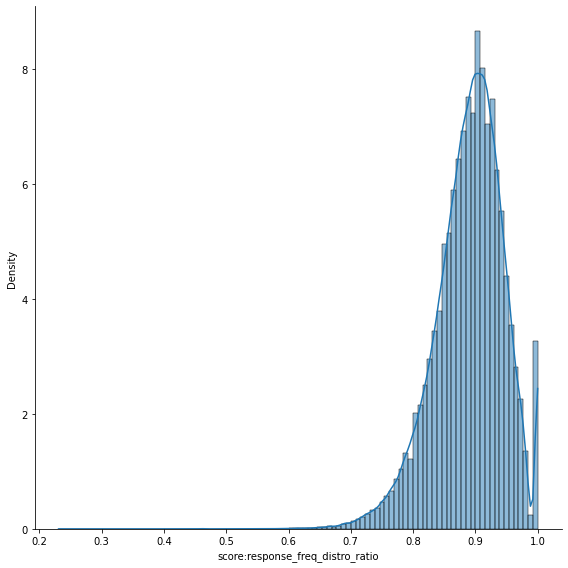

In [52]:
g3 = sns.displot(
    data=df,
    x='score:response_freq_distro_ratio', 
    kde=True, 
    stat='density', 
    common_bins=False, 
    common_norm=False, 
    height=8,
    bins=100,
)


# fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# sns.histplot(df['score:response_freq_distro_ratio'], bins=100, kde=False, stat='density', ax=ax)
# ax.set_xlim(0.0,1.1)
# ax.set_xticks(list(np.arange(0.0, 1.1, 0.05)))
# ax.set_xlabel('Target text unigram distribution')
# ax.set_ylabel('Count')

In [12]:
# Inspect examples according to certain thresholds

filt_freq_distro_min = 0.0
filt_freq_distro_max = 0.883

filt_generic_sent_avg_min = 0.0
filt_generic_sent_avg_max = 0.7

filt_response_tfidf_min = 1.37
filt_response_tfidf_max = 1.8

filt_tgt_ppl_min = 23.5
filt_tgt_ppl_max = 50

x = df[(
    df['score:response_freq_distro_ratio'] > filt_freq_distro_min
) & (
    df['score:response_freq_distro_ratio'] < filt_freq_distro_max
) & (
    df['score:genericness_sent_level_sts_avg'] > filt_generic_sent_avg_min
) & (
    df['score:genericness_sent_level_sts_avg'] < filt_generic_sent_avg_max
) & (
    df['score:response_tfidf'] > filt_response_tfidf_min
) & (
    df['score:response_tfidf'] < filt_response_tfidf_max
) & (
    df['score:response_text_ppl'] > filt_tgt_ppl_min
) & (
    df['score:response_text_ppl'] < filt_tgt_ppl_max
)]

print(len(x))
print(x['response_clean_len'].describe())

41894
